# End-To-End Machine Learning Project

This notebook is demostrating an end to end Machine Learning example project to build a model of housing prices for a real state company in California. It will walk you through the foolowing steps:
1. Frame the problem.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms. 
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

## Frame the Problem

In this phase we should seek for answers to the following questions:
1. What exactly is the business objective? 
  * To use the model output to fed another Machine Learning system.
2. Are they any previous solutions, and if so, how accurate are they and how they were built?
  * Complex rule based manually estimated by market experts.
  * The current error rate is about 15%.
3. How does the company expect to use and benefit from this model?
  * Decrease the cost, time and error of the current system.
4. What data sources are currently available?
  * California Census Data, containing metrics such as the population, median income, median housing price, and so on for each block group in California.
5. Is it a supervised, unsupervised or reinforcement learning?
  * Supervised learning since the data contained the labels.
6. What king of task it is?
  * A Multivariate Regression task since the model needs to predict a continous value out of multiple features.
7. Should we use batch learning or online learning techniques?
  * Batch Learning since there is no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory.

## Select a Performace Measure

A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It measures the standard deviation of the errors the system makes in its predictions. The mathematical formula to calculate the RMSE is the following:

$RMSE(X,f) = \sqrt[2]{\frac{1}{n}\sum_{i=1}^{n}(f(x^{(i)}) - y^{(i)})^2}$

Where:

$X$: is a matrix of n rows (instances) and m columns (features).

$f$: is the predicting function or model.

$x^{(i)}$: is the row $i$ of the matrix $X$.

$f(x^{(i)})$: is the predicted value for the point $x^{(i)}$ in the $m$ dimentional space.

$y^{(i)}$: is the real value of the for the row $i$ of the matrix $X$.



## Verify the Assumptions

Our approach is assuming that the Machine Learning System to be fed by our model is expecting a continous quantitative value, reason why we classified the task as a regression. What if they are actually expecting a range or interval instead of a value. In this case our task would have being a classification instead of regression. Let supposed that our assumption was comfirmed.

## Preparing the environment

In [108]:
from io import BytesIO
from urllib.request import urlopen
from tarfile import TarFile
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler,label_binarize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import random
import os
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt

pd.set_option('display.precision', 3)

## Getting the Data

In [28]:
ROOT_DIR="https://raw.githubusercontent.com/ageron/handson-ml/master/"
REL_PATH="datasets/housing/"
FILE_NAME='housing.tgz'
URL = ROOT_DIR + REL_PATH + FILE_NAME

def fetch_data(url):
    response = urlopen(URL)
    compress_file = TarFile.open(fileobj=BytesIO(response.read()))
     # Decompressing the file and loading it into a Python Data Frame
    file = compress_file.extractfile(compress_file.members.pop())
    data=pd.read_csv(file)
    compress_file.close()
    return(data)

data=fetch_data(URL)

## Understanding the Data

In [5]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.325,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.301,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.257,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.643,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.846,342200.0,NEAR BAY


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000,20640.000,20640.000,20640.000,20433.000,20640.000,20640.00,20640.000,20640.000
mean,-119.570,35.632,28.639,2635.763,537.871,1425.477,499.54,3.871,206855.817
std,2.004,2.136,12.586,2181.615,421.385,1132.462,382.33,1.900,115395.616
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.00,0.500,14999.000
25%,-121.800,33.930,18.000,1447.750,296.000,787.000,280.00,2.563,119600.000
50%,-118.490,34.260,29.000,2127.000,435.000,1166.000,409.00,3.535,179700.000
75%,-118.010,37.710,37.000,3148.000,647.000,1725.000,605.00,4.743,264725.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.00,15.000,500001.000


In [8]:
data.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

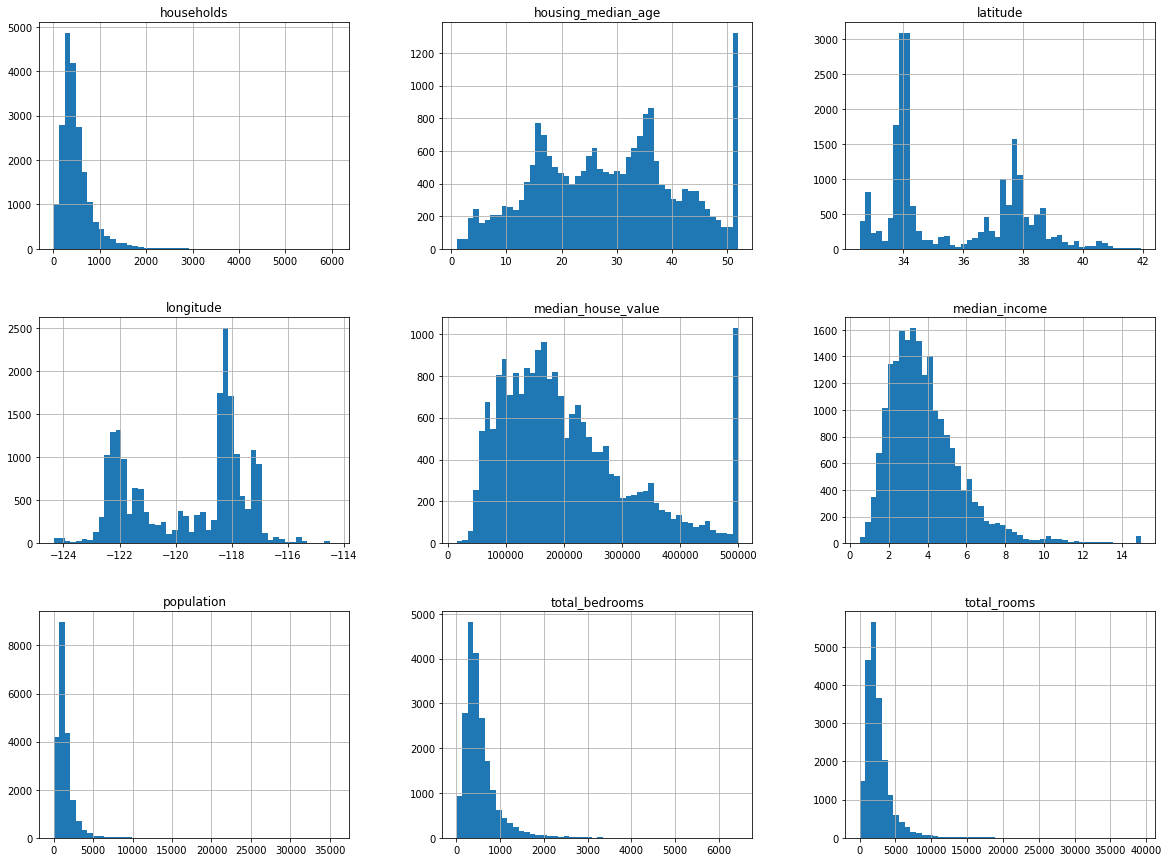

In [9]:
data.hist(bins=50,figsize=(20,15))
plt.show()

Notice a few things in these histograms:
1. The median income attribute does not look like it is expressed in US dollars (USD. After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes.
2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond 500,000, then you have mainly two options:
  * Collect proper labels for the districts whose labels were capped.
  * Remove those block groups from the data set.
3. These attributes have very different scales.
4. Finally,many histograms are highly right skewed. This may make it a bit harder for some Machine Learning algorithms to detect patterns. Therefore they might need to be transformed to have more normal or bell-shaped distributions.

## Split the data into Train and Test Datasets

In [85]:
train, test = train_test_split(data,test_size=0.2,random_state=100)
train_set = train.copy()
test_set = test.copy()

### Verifying Sampling Bias

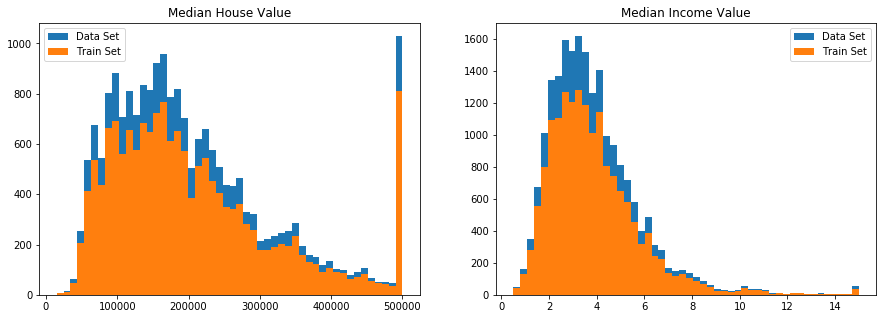

In [86]:
fig=plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.hist(data.median_house_value,bins=50,label='Data Set')
ax1.hist(train_set.median_house_value,bins=50,label='Train Set')
ax2.hist(data.median_income,bins=50,label='Data Set')
ax2.hist(train_set.median_income,bins=50,label='Train Set')
ax1.legend(loc='best')
ax2.legend()
ax1.set_title('Median House Value')
ax2.set_title('Median Income Value')
plt.show()

We can see in the previous visualization that both variables are equally distributed in the training set when compared with the full data set. This indicates that our training set is representative of our full dataset. However, let also implement a stratified sampling by median income and determine which of the two sampling methodologies has the lower sampling bias.

First, we need to discretizes the median icome feature to create categories based on quantiles.

In [87]:
data.loc[:,'median_income_cat']=pd.qcut(data.median_income,10)
data.median_income_cat.value_counts()

(2.74, 3.141]     2068
(3.967, 4.438]    2066
(0.499, 1.904]    2066
(6.159, 15.0]     2064
(5.11, 6.159]     2064
(3.535, 3.967]    2064
(1.904, 2.352]    2064
(2.352, 2.74]     2063
(4.438, 5.11]     2062
(3.141, 3.535]    2059
Name: median_income_cat, dtype: int64

Now let's performed the stratified sampling based of the median house value categories.

In [88]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.20,random_state=100)
for train_index, test_index in split.split(data,data.median_income_cat):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]

Finally, let's compare the sampling error for both the simple ramdom sample and the stratified sample. To do this we first need to create the same median house value categories for our simple random sample.

In [84]:
#del train_set['median_income_cat']
del data['median_income_cat']
train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'median_income_cat'],
      dtype='object')

In [90]:
train_set.loc[:,'median_income_cat']=pd.cut(train_set.median_income,data.median_income_cat.values.categories)
sampling_error=pd.DataFrame({'Full_Dataset':data.median_income_cat.value_counts()/len(data),\
                             'Random_Sample':train_set.median_income_cat.value_counts()/len(train_set),\
                             'Strat_Sample':strat_train_set.median_income_cat.value_counts()/len(strat_train_set)})
sampling_error.loc[:,'Random_Error(%)']=np.divide(np.subtract(sampling_error.Random_Sample,sampling_error.Full_Dataset),sampling_error.Full_Dataset)*100
sampling_error.loc[:,'Strat_Error(%)']=np.divide(np.subtract(sampling_error.Strat_Sample,sampling_error.Full_Dataset),sampling_error.Full_Dataset)*100
sampling_error

,Full_Dataset,Random_Sample,Strat_Sample,Random_Error(%),Strat_Error(%)
"(0.499, 1.904]",0.1,0.100,0.1,0.375,0.012
"(1.904, 2.352]",0.1,0.101,0.1,1.078,-0.012
"(2.352, 2.74]",0.1,0.100,0.1,0.400,-0.024
"(2.74, 3.141]",0.1,0.100,0.1,-0.266,0.036
"(3.141, 3.535]",0.1,0.097,0.1,-2.562,-0.012
"(3.535, 3.967]",0.1,0.100,0.1,-0.133,-0.012
"(3.967, 4.438]",0.1,0.102,0.1,1.948,0.012
"(4.438, 5.11]",0.1,0.099,0.1,-0.764,0.024
"(5.11, 6.159]",0.1,0.100,0.1,0.291,-0.012
"(6.159, 15.0]",0.1,0.097,0.1,-2.616,-0.012


Before we move on we should remove the recent added median house value categories from all the datasets we added to.

In [91]:
for set in[data,train_set,strat_test_set,strat_train_set]:
    del set['median_income_cat']

## Discover and Visualize the Training Data to Gain Insights

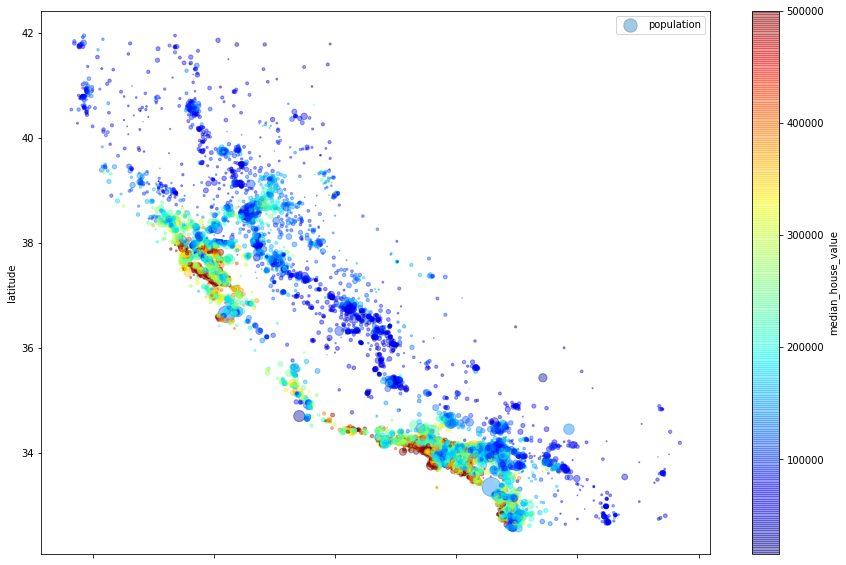

In [92]:
strat_train_set_copy = strat_train_set.copy()
strat_train_set_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=strat_train_set_copy["population"]/100, \
                    figsize=(15,10),label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
) 
plt.legend()
plt.show()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density.

### Looking for Correlation

In [93]:
corr_matric = strat_train_set_copy.corr()
corr_matric.median_house_value.sort_values(ascending=False)

median_house_value    1.000
median_income         0.689
total_rooms           0.134
housing_median_age    0.116
households            0.069
total_bedrooms        0.052
population           -0.023
longitude            -0.049
latitude             -0.144
Name: median_house_value, dtype: float64

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot.

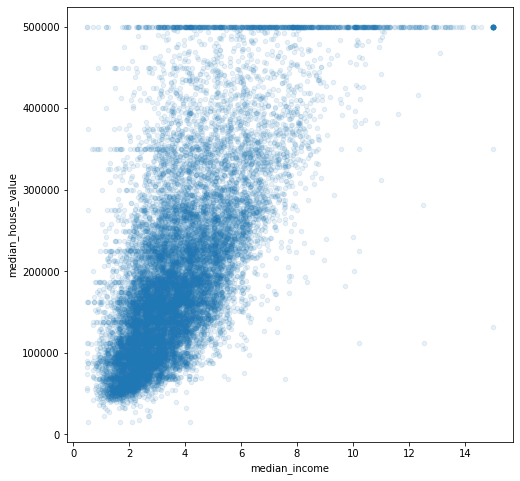

In [94]:
strat_train_set_copy.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1,figsize=(8,8))

This plot reveals the foolowing: 
1. The correlation is indeed very strong
2. There are more median house value caps than we noticed earlier at 500,000 dollars. For instance, notice the horizontal line around 450,000 and another around 350,000. 

We might need to consider removing the corresponding block groups to prevent learning algorithms from learning to reproduce these data quirks.

## Feature Engineering

Now let's construct new features out of the existing ones and look at their correlation with the median house value feature.

In [95]:
strat_train_set_copy["rooms_per_household"] = strat_train_set_copy["total_rooms"]/strat_train_set_copy["households"]
strat_train_set_copy["bedrooms_per_room"] = strat_train_set_copy["total_bedrooms"]/strat_train_set_copy["total_rooms"]
strat_train_set_copy["population_per_household"]=strat_train_set_copy["population"]/strat_train_set_copy["households"]

In [96]:
strat_train_set_copy.corr().median_house_value.sort_values(ascending=False)

median_house_value          1.000
median_income               0.689
rooms_per_household         0.141
total_rooms                 0.134
housing_median_age          0.116
households                  0.069
total_bedrooms              0.052
population                 -0.023
population_per_household   -0.033
longitude                  -0.049
latitude                   -0.144
bedrooms_per_room          -0.252
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute has a higher correlation with the median_house_value feature than the total_bedrooms or total_rooms features. It seems that houses with a lower bedroom/room ratio tend to be more expensive. The rooms_per_household feature is also more informative than the total_rooms feature.

## Prepare the Data for Machine Learning Algorithms

In [97]:
X_DF = strat_train_set.drop('median_house_value',axis=1)
Y = strat_train_set['median_house_value'].copy()

### Data Cleaning

Most Machine Learning algorithms cannot work with features with missing values, so we need to handle them before training the algorithms. To handle these missing values we have the following three options:
1. Removing the instances with the missing values.
2. Removing the entire feature with missing values from the training and test sets.
3. Impute the missing values.

Earlier we noticed that the feature total_bedrooms include missing values. Let impute these missing values by using the median of this feature.

In [98]:
X_DF_Quant = strat_train_set.drop('ocean_proximity',axis=1) 
imputer = SimpleImputer(strategy='median')
imputer.fit(X_DF_Quant)
X_DF_Quant = pd.DataFrame(imputer.transform(X_DF_Quant),columns=X_DF_Quant.columns)
X_DF_Quant

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-118.38,33.95,35.0,3259.0,967.0,2003.0,920.0,3.271,400000.0
1,-117.11,32.84,16.0,4608.0,629.0,2020.0,636.0,6.040,243000.0
2,-122.38,40.56,23.0,2281.0,408.0,1164.0,420.0,3.535,101200.0
3,-122.26,37.85,50.0,1120.0,283.0,697.0,264.0,2.125,140000.0
4,-118.31,33.90,38.0,1400.0,399.0,1131.0,405.0,3.542,198400.0
...,...,...,...,...,...,...,...,...,...
16507,-121.97,37.93,4.0,3241.0,464.0,1552.0,494.0,6.613,307000.0
16508,-121.28,38.60,25.0,1122.0,198.0,564.0,213.0,3.165,111600.0
16509,-120.02,39.24,22.0,2309.0,571.0,919.0,342.0,3.006,93600.0
16510,-118.33,33.91,35.0,1092.0,302.0,962.0,297.0,3.590,183300.0


### Handling Text and Categorical Attributes

In [99]:
encoder = LabelBinarizer()
ocean_prox = strat_train_set.ocean_proximity.copy()
ocean_prox_endoded = encoder.fit_transform(ocean_prox)
ocean_prox_endoded

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

### Custom Transformations

To create your own transformers so that they work seamlessly with other Scikit-Learn functionalities (such as pipelines), all we need to do is to create a class that implements the following e methods:
1. fit (returning self)
2. transform: to apply the learnined transformation
3. fit_transform: to learn and apply the trasformation. We can inherit this method by extending the TransformerMixin class. If we also extend the BaseEstimator and avoid the \*args and \*\*kargs in the constructor we will get additional methods like the get_params and set_params methods.

To ilustrate this let create a custom transformer to add the additional features we calculated previously.

In [100]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.rooms_ix = pd.Index(strat_train_set.columns).get_loc('total_rooms')
        self.bedrooms_ix = pd.Index(strat_train_set.columns).get_loc('total_bedrooms')
        self.population_ix = pd.Index(strat_train_set.columns).get_loc('population')
        self.household_ix = pd.Index(strat_train_set.columns).get_loc('households')
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:,self.rooms_ix] / X[:,self.household_ix] 
        population_per_household = X[:,self.population_ix] / X[:,self.household_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,self.bedrooms_ix] / X[:,self.rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) 
X_Quant_Extra_Attr = attr_adder.transform(X_DF_Quant.values)

### Feature Scaling

Feature scaling is one of the most important transformations that needs to be apply to the data prior to training any learning algorithms. The reason for this is that must Machine Learning algorithms don’t perform well with quatitative attributes have very different scales. The two must common methods to scale attribute are the following:
1. Min-Max Scaling (Normalization): The attributes are scaled to fall in the interval [0,1]. The mathematical formula to scale the value i of the attribute X is given by $\frac{X_i - min(X)}{max(X) - min(X)}$
2. Standardization: Scale the attribute so that the mean is equal to 0 and the variance is equal to 1. The mathematical formula to scale the value i of the attribute X is given by $\frac{X_i - mean(X)}{std(X)}$

In [101]:
std_scaler = StandardScaler()
X_Quant_Extra_Attr_Scaled = std_scaler.fit_transform(X_Quant_Extra_Attr)
print(np.apply_along_axis(np.mean,0,X_Quant_Extra_Attr_Scaled))
print(np.apply_along_axis(np.std,0,X_Quant_Extra_Attr_Scaled))

[ 6.54192462e-16 -1.87403925e-16 -7.29390708e-17  5.89537032e-17
  1.29095701e-17  2.15159501e-18  6.28265743e-17  1.15110333e-16
  1.07579750e-16 -2.36137552e-16  1.82347677e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Transformation Pipelines

So far we had applied the following transformations to our training set:
1. Separeted the quantitative and qualitative attributes.
2. Inputed missing values.
3. Added additional attributes.
4. Scaled the quantitatives attributes.

To applied this trasnformation in order and in a more automated way we can use the transformations pipelines available in Scykit-Learn.

In [116]:
class AttributeSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values

class MyLabelBinarizer(BaseEstimator, TransformerMixin):
    
    def __init__(self,classes):
        self.classes_ = classes
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return label_binarize(x,self.classes_)

In [117]:
quant_pipeline = Pipeline([('selector',AttributeSelector(list(X_DF.select_dtypes(exclude=['object','category'])))),
                            ('inputer',SimpleImputer(strategy='median')),
                           ('attr_adder',CombinedAttributesAdder())
                           ,('std_scaler',StandardScaler())])

qual_pipeline = Pipeline([('selector',AttributeSelector(list(X_DF.select_dtypes(include=['object','category'])))),
                           ('label_binarizer',MyLabelBinarizer(X_DF.ocean_proximity.unique()))])

full_pipeline = FeatureUnion(transformer_list=[('quant_pipeline',quant_pipeline),
                                               ('qual_pipeline',qual_pipeline)])
X_Prepared = full_pipeline.fit_transform(X_DF)
print(X_Prepared.shape)

(16512, 16)


## Training and Evaluating using the Training Set

### Training a Linear Regresssion

In [124]:
linear_reg = LinearRegression()
linear_reg.fit(X_Prepared, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Making Predictions

In [125]:
small_index = random.sample(list(X_DF.index),5)
small_sample = X_DF.loc[small_index,:]
small_sample_prepared = full_pipeline.fit_transform(small_sample)
print(linear_reg.predict(small_sample_prepared))
print(list(Y[small_index]))

[211520. 252544. 179200.  61312. 240384.]
[209400.0, 194100.0, 88700.0, 96300.0, 277000.0]


In [126]:
linear_pred = linear_reg.predict(X_Prepared)
linear_rmse = np.sqrt(mean_squared_error(linear_pred,Y))
linear_rmse

68246.80909451749

The training error of the Linear Regression model is \$68,246. This error is not a satisfying one 

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_Prepared,Y)
tree_pred = tree_reg.predict(X_Prepared)
tree_rmse = np.sqrt(mean_squared_error(tree_pred,Y))
tree_rmse

Can this be the best model since it has a 0 RMSE? It is possible that this model has badly overfit the data. How can we verify this? We don't want to touch the test set until we adentified the most accurate model that we are confident about, so we need to use part of the training set for training, and part for model validation.

### K-fold Cross Validation

In [160]:
tree_cross_scores = cross_val_score(tree_reg, X_Prepared, Y,scoring="neg_mean_squared_error", cv=4)
tree_cross_rmse = np.sqrt(-tree_cross_scores)
pd.Series(tree_cross_rmse).describe()

count        4.000
mean     71028.652
std        557.233
min      70566.281
25%      70615.121
50%      70890.638
75%      71304.169
max      71767.052
dtype: float64

In [163]:
linear_cross_scores = cross_val_score(linear_reg,X_Prepared,Y,scoring='neg_mean_squared_error',cv=4,random_state=100)
linear_cross_rmse = np.sqrt(-linear_cross_scores)
pd.Series(linear_cross_rmse).describe()

TypeError: cross_val_score() got an unexpected keyword argument 'random_state'

In [162]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_Prepared,Y)
forest_pred = forest_reg.predict(X_Prepared)
forest_rmse = np.sqrt(mean_squared_error(forest_pred,Y))
print(forest_rmse)
forest_cross_scores = cross_val_score(forest_reg,X_Prepared,Y,scoring='neg_mean_squared_error',cv=4)
forest_cross_rmse = np.sqrt(-forest_cross_scores)
pd.Series(forest_cross_rmse).describe()

18398.68333816348


count        4.000
mean     49779.138
std        507.707
min      49199.789
25%      49442.999
50%      49804.909
75%      50141.047
max      50306.948
dtype: float64

### Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 20, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [10, 20], 'max_features': [2, 4, 6]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)